In [139]:
% pylab inline
import pandas as pd
#import numpy as np
import matplotlib as plt
import nltk
from nltk.corpus import stopwords 
import string
import heapq
import operator
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Dropout, Activation


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Populating the interactive namespace from numpy and matplotlib


C:\Users\aviv\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aviv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [140]:
import pandas as pd
data_df=pd.read_csv('gender-classifier-DFE-791531.csv',header=0,encoding = 'latin1') #iso-8859-1

In [141]:
print(data_df.axes)

[RangeIndex(start=0, stop=20050, step=1), Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')]


In [142]:
def clean(words_string):    
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    stop_free=" ".join([i for i in words_string.lower().split() if i not in stop])
    punc_free=''.join(ch if ch not in exclude else ' ' for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

def uniteLists(list_of_lists_of_words):
    united=[]
    for list_of_words in list_of_lists_of_words:
        united+=list_of_words
    return united
def devideToTermsAndFreq(tfList):
    ans_terms=[]
    ans_freq=[]
    for key,val in tfList:
        ans_terms.append(key)
        ans_freq.append(val)
    return ans_terms,ans_freq
def createPlot(x_data,y_data,y_name,x_name,title,i,j,k,color,bartype):
    axis_font = {'family': 'serif','color':  'black','weight': 'normal','size': 18,}
    title_font = {'family': 'serif','color':  'black','weight': 'normal','size': 22,}
    font_size=16
    df=pd.DataFrame(data={x_name:x_data,y_name:y_data})
    temp = df.pivot_table(values=y_name,index=x_data)
    temp.sort_values(by=(y_name), ascending=True,inplace=True)
    ax = fig.add_subplot(i,j,k) #121
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)
    ax.set_xlabel(x_name,fontdict=axis_font)
    ax.set_ylabel(y_name,fontdict=axis_font)
    ax.set_title(title,fontdict=title_font)
    temp.plot(kind=bartype,ax=ax,cmap=color)

### cleaning the data

In [143]:
import re
data_df = data_df[data_df['gender'].apply(lambda x : (x=='male' or x=='female') )]
data_df['text']=data_df['text'].apply(lambda x :  re.sub('(htt\S+)',"",x))
data_df['text']=data_df['text'].apply(lambda x :  re.sub('[^a-zA-Z0-9 #@]+',"",x))
data_df['hashtags']=data_df['text'].apply(lambda x :  re.findall('#[a-zA-Z]+',x))
data_df['user_tag']=data_df['text'].apply(lambda x :  re.findall('@[a-zA-Z]+',x))
data_df['clean_text']=data_df['text'].apply(lambda x :  re.sub('[#@]\S+\s*',"",x))
data_df['clean_text']=data_df['clean_text'].apply(clean)
data_df['clean_words_list']=data_df['clean_text'].apply(lambda x:re.findall('[a-zA-Z0-9]+',x))

- **'text'**- sentence per user cleaned from http links and garbage letters.
- **'hashtag'**- list of #hashtags per user.
- **'user_tag'** - list of @user_tags per user.
- **'clean_text'**- same as 'text' just without #tags and @tags.
- **'clean_words_list'**- same as 'clean_text' just splitted to list of words per user.

### male/female_tf contains all the terms with there frequencies. 

In [144]:
male_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x=='male')])
female_words=uniteLists(data_df['clean_words_list'][data_df['gender'].apply(lambda x: x=='female')])
male_tf = Counter(male_words).most_common()
female_tf=Counter(female_words).most_common()

### plot of the num most common terms for male and female

C:\Users\aviv\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The Vega10_r colormap was deprecated in version 2.0. Use tab10_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


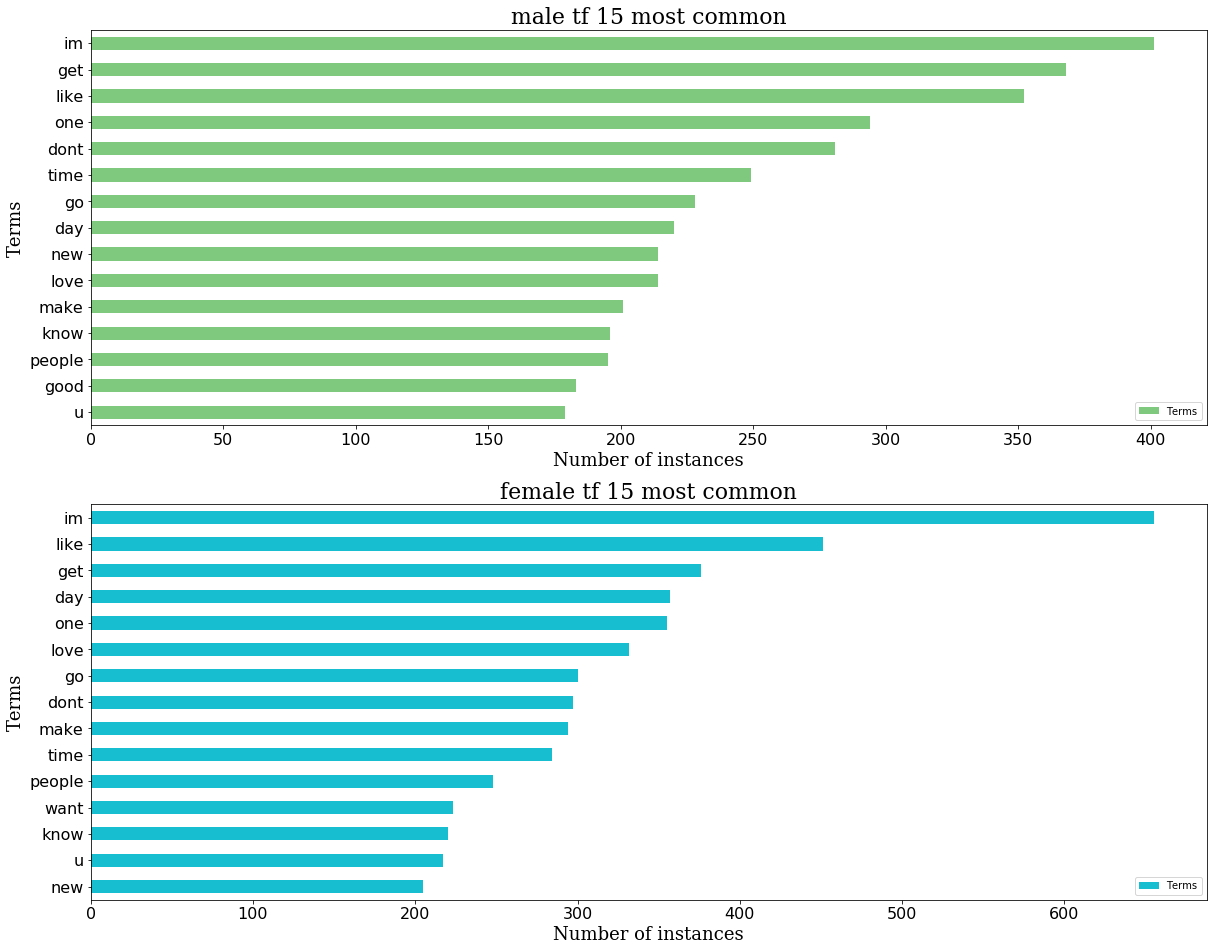

In [145]:
num=15
fig = plt.figure(figsize=(20,16))
terms,freq=devideToTermsAndFreq(male_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common'%(num) ,2,1,1,'Accent','barh')
terms,freq=devideToTermsAndFreq(female_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common'%(num),2,1,2,'Vega10_r','barh')

### male/female_hashtag_tf contains all the hashtags with there frequencies. 


In [146]:
male_hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x=='male')])
female_hashtag_words=uniteLists(data_df['hashtags'][data_df['gender'].apply(lambda x: x=='female')])
male_hashtag_tf = Counter(male_hashtag_words).most_common()
female_hashtag_tf=Counter(female_hashtag_words).most_common()

### plot for num most common #hashtags

C:\Users\aviv\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The Vega20c colormap was deprecated in version 2.0. Use tab20c instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\aviv\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The Vega20b_r colormap was deprecated in version 2.0. Use tab20b_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


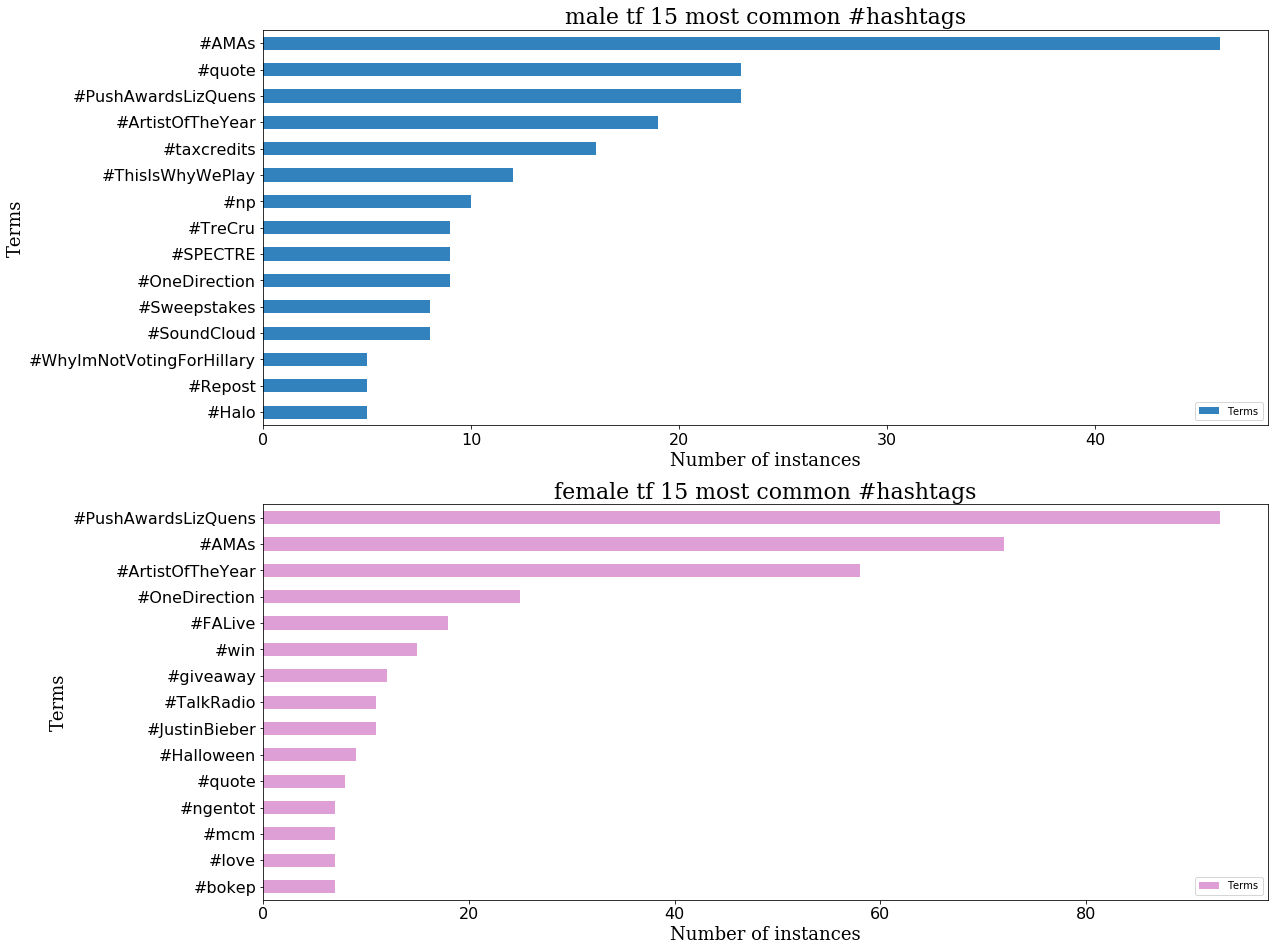

In [147]:
num=15
fig = plt.figure(figsize=(18,16))
terms,freq=devideToTermsAndFreq(male_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','male tf %s most common #hashtags'%(num),2,1,1,'Vega20c','barh')
terms,freq=devideToTermsAndFreq(female_hashtag_tf)
createPlot(terms[:num],freq[:num],'Terms','Number of instances','female tf %s most common #hashtags'%(num),2,1,2,'Vega20b_r','barh')

# /////////////////////////////////////////////////////////////////////////////////////////////////////////

In [148]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [149]:
corpus=data_df['text'].tolist()[:500]
X = vectorizer.fit_transform(corpus)

In [150]:
def changeGenderToNum(word):
    if word=='male':
        return 1 
    return 0
def changeNumToGender(num):
    if num==0:
        return 'female' 
    return 'male'
data_df['num_gender']=data_df['gender'].apply(changeGenderToNum)
Y=data_df['num_gender'][:500].tolist()

In [151]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

def benchmark(clf,X_train,y_train):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    X_test=X_train
    y_test=y_train
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []

# from keras.utils import to_categorical
# y_binary = to_categorical(Y)

#DLmodel = Sequential()
#DLmodel.add(Dense(500,input_shape=(2593,), activation='relu'))
#DLmodel.add(Dropout(0.5))
#DLmodel.add(Dense(256, activation='sigmoid'))
#DLmodel.add(Dropout(0.5))
# DLmodel.add(Dense(0, activation='softmax'))
# DLmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

# DLmodel.fit(X, y=y_binary, batch_size=2593, nb_epoch=10, verbose=1, validation_split=0.2)


# DLmodel.add(Embedding(input_dim=X.shape[0],output_dim= 500, input_length=X.shape[1]))
# DLmodel.add(Flatten())
# DLmodel.add(Dense(200, activation='sigmoid'))
# DLmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])
# DLmodel.fit(X, y=Y, batch_size=200, nb_epoch=10, verbose=1, validation_split=0.2)
# scores = model.evaluate(X, Y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
SVM=SGDClassifier()
PER=Perceptron()
NB=MultinomialNB()
KN=KNeighborsClassifier(15)
for clf, name in (
        (SVM,"SVM"),
        (KN, "kneighbors"),
        (NB,"Naive Bayes")
    ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf,X,Y))


SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.011s
test time:  0.001s
accuracy:   0.978

kneighbors
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
train time: 0.008s
test time:  0.116s
accuracy:   0.572

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.020s
test time:  0.00

C:\Users\aviv\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [152]:
changeNumToGender(SVM.predict(vectorizer.transform(['there is a football game this monday']).toarray())[0])

'male'

## Get most tweeted country

In [153]:
locations = data_df['tweet_location'][data_df['tweet_location'].apply(lambda x: type(x) == str)]
locations=locations.apply(clean)
locations_tf = Counter(locations).most_common()
locations_tf

[('london', 120),
 ('los angeles ca', 57),
 ('uk', 53),
 ('united state', 50),
 ('los angeles', 46),
 ('new york', 41),
 ('lagos nigeria', 38),
 ('london england', 36),
 ('', 36),
 ('nyc', 34),
 ('chicago il', 33),
 ('atlanta ga', 33),
 ('usa', 32),
 ('texas', 32),
 ('california', 32),
 ('boston', 31),
 ('canada', 31),
 ('new york ny', 30),
 ('chicago', 30),
 ('united kingdom', 29),
 ('washington dc', 28),
 ('houston tx', 26),
 ('austin tx', 26),
 ('england', 25),
 ('toronto', 25),
 ('san francisco ca', 21),
 ('england united kingdom', 21),
 ('manchester', 20),
 ('philadelphia pa', 20),
 ('florida', 19),
 ('\x89ã\x8farry laura \x88â»\x88âò', 19),
 ('scotland', 18),
 ('new york city', 18),
 ('ohio', 17),
 ('seattle wa', 17),
 ('atlanta', 16),
 ('nigeria', 15),
 ('earth', 15),
 ('brooklyn ny', 15),
 ('seattle', 15),
 ('glasgow', 14),
 ('charlotte nc', 14),
 ('italy', 14),
 ('michigan', 14),
 ('houston', 14),
 ('denver co', 14),
 ('ireland', 13),
 ('lagos', 13),
 ('birmingham', 13),
 ('lo

## Question 3

In [154]:
import tweepy
from tweepy import OAuthHandler

consumer_key = 'aZgjP0NZeM4iiBaQXJcyOKLJB'
consumer_secret = 'VRLyop5JLP8Kh91CMnE0rpOKUhKEtrrVTCOozHVOd8QEFx69XX'
access_token = '326266960-9RZItG8Q4FUER0BOX4eO8mrvsvrrDWzaWiJqoens'
access_secret = 'v6UHn9puTUv5OgcDwGqf3UxfCZv6XSJZ1gB8UkXOFrnQo'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)

In [232]:
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import os

In [239]:
JSON_FILE_NAME='usa_tweets.json'
MAX_NUMBER_OF_TWEETS = 10
tweets_gathered = 0
f = open(JSON_FILE_NAME, 'w')
f.write('[')
#writer = csv.writer(f)
class MyListener(StreamListener):
    
    def on_data(self, data):
        global tweets_gathered
        if MAX_NUMBER_OF_TWEETS > tweets_gathered:
            tweets_gathered += 1
            try:
                #print(api.get_user(json.loads(data)['user']['id'])['gender']) - sadly will not work..
                f.write(data.rstrip() + ',')
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            f.seek
            return False
 
    def on_error(self, status):
        print(status)
        return True
 
twitter_stream = Stream(auth, MyListener())
# those coordinates are boxed that represents most of america - the country that we've found to have the most tweetings. 
twitter_stream.filter(locations=[-124.89,32.7,-93.07,48.99,
                                 -110.64,31.98,-84.43,47.01,
                                -99.04,26.29,-72.83,41.58,
                                -79.0,32.1,-70.6,43.69,
                                -75.3,41.06,-66.91,45.06])
f.close()
#just a fix to the json file
with open(JSON_FILE_NAME, 'rb+') as f:
    f.seek(-1, os.SEEK_END)
    f.write(b']')
    

In [228]:
new_twitts_df = pd.read_json(path_or_buf=JSON_FILE_NAME)
display(new_twitts_df)
# Can't get twitts gender - arghhhh

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,source,text,timestamp_ms,truncated,user
0,NaN,None,2018-01-20 23:05:25,"[12, 39]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,954852391949668353,954852391949668352,dank_bagel,9.548483e+17,9.548483e+17,2.989582e+07,2.989582e+07,False,en,"{'id': '8e9665cec9370f0f', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...",@dank_bagel but is it decent quality???,2018-01-20 23:05:25.197,False,"{'id': 245152688, 'id_str': '245152688', 'name..."
1,NaN,None,2018-01-20 23:05:25,"[22, 29]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,954852392008339456,954852392008339456,HopeFloeck,9.548135e+17,9.548135e+17,1.552124e+09,1.552124e+09,False,en,"{'id': 'f7bb6752fbd343e9', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@HopeFloeck @LassMike Oh no!!,2018-01-20 23:05:25.211,False,"{'id': 710864108992602112, 'id_str': '71086410..."
2,NaN,None,2018-01-20 23:05:25,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,{'full_text': 'i wonder if mike pence will cal...,0,False,low,None,954852392557834241,954852392557834240,None,NaN,NaN,NaN,NaN,False,en,"{'id': '00f751614d8ce37b', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",i wonder if mike pence will call my student lo...,2018-01-20 23:05:25.342,True,"{'id': 19188730, 'id_str': '19188730', 'name':..."
3,NaN,None,2018-01-20 23:05:25,"[15, 53]","{'hashtags': [{'text': 'prfest', 'indices': [1...",NaN,NaN,0,False,low,None,954852392473890818,954852392473890816,CoachCloutier,9.547065e+17,9.547065e+17,8.789985e+08,8.789985e+08,False,en,"{'id': 'ed2f91f4683ea25f', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@CoachCloutier #prfest w Mohon girls too! #moh...,2018-01-20 23:05:25.322,False,"{'id': 3525012017, 'id_str': '3525012017', 'na..."
4,NaN,None,2018-01-20 23:05:25,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,954852392796872704,954852392796872704,None,NaN,NaN,NaN,NaN,False,en,"{'id': '813a485b26b8dae2', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",Heaven so close I could kiss it,2018-01-20 23:05:25.399,False,"{'id': 922318724, 'id_str': '922318724', 'name..."
5,NaN,"{'type': 'Point', 'coordinates': [-79.41933056...",2018-01-20 23:05:25,NaN,"{'hashtags': [{'text': 'wychwoodpark', 'indice...",NaN,NaN,0,False,low,"{'type': 'Point', 'coordinates': [43.67806111,...",954852393002389505,954852393002389504,None,NaN,NaN,NaN,NaN,False,pl,"{'id': '3797791ff9c0e4c6', 'url': 'https://api...",0.0,0,NaN,NaN,NaN,0,0,False,"<a href=""http://instagram.com"" rel=""nofollow"">...",#wychwoodpark #wychwood #winter #wintermission...,2018-01-20 23:05:25.448,False,"{'id': 775017472416186368, 'id_str': '77501747..."
6,NaN,None,2018-01-20 23:05:25,"[12, 50]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,None,954852393182744578,954852393182744576,adaojiakor,9.548521e+17,9.548521e+17,1.713060e+08,1.713060e+08,False,en,"{'id': '38d5974e82ed1a6c', 'url': 'https://api...",NaN,0,NaN,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@adaojiakor I stopped eating after the second ...,2018-01-20 23:05:25.491,False,"{'id': 226996684, 'id_str': '226996684', 'name..."
7,NaN,"{'type': 'Point', 'coordinates': [-122.39872, ...",2018-01-20 23:05:25,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...